In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.2', 'mag_i_cModel > 15',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28.9','mag_i>15',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

# z filters (grande):

object_z_filters = ['photoz_mean < 1.5', (np.isfinite, 'photoz_mean')]

truth_z_filters = ['redshift < 1.5', (np.isfinite, 'redshift')] 

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters+object_z_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters+truth_z_filters, 
                                      native_filters=healpix_filter))

In [9]:
list(truth_data)

['redshift', 'halo_mass', 'ra', 'mag_i', 'is_central', 'dec', 'galaxy_id']

In [10]:
truth_data['halo_mass']

array([5.07006249e+12, 5.07006249e+12, 3.79915201e+10, ...,
       3.66026775e+10, 2.66634575e+10, 1.77529818e+10])

In [11]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2895422
nombre de galaxies centrales = 2735018
pourcentage de galaxies centrales = 94.46008215728139 %
nombre d'objets = 538285


In [12]:
truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]]

array([23.95609176, 27.467791  , 23.78634715, ..., 28.12386336,
       27.58106806, 28.8712917 ])

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07]),
 [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

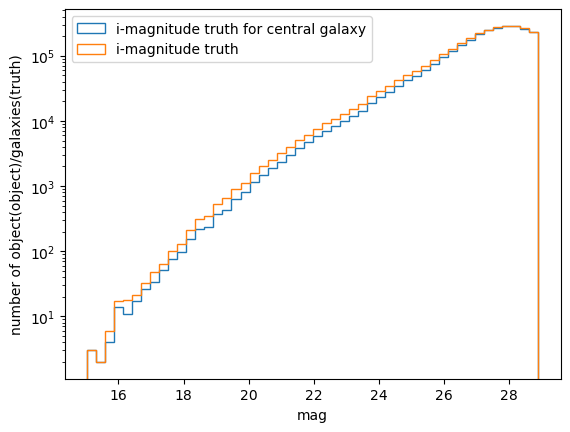

In [37]:
plt.figure()
truth_hist_central=plt.hist(truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='i-magnitude truth for central galaxy', log=True)
truth_hist=plt.hist(truth_data['mag_i'], bins=50, histtype='step', label='i-magnitude truth', log=True)
plt.legend()
plt.xlabel('mag')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07]),
 [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

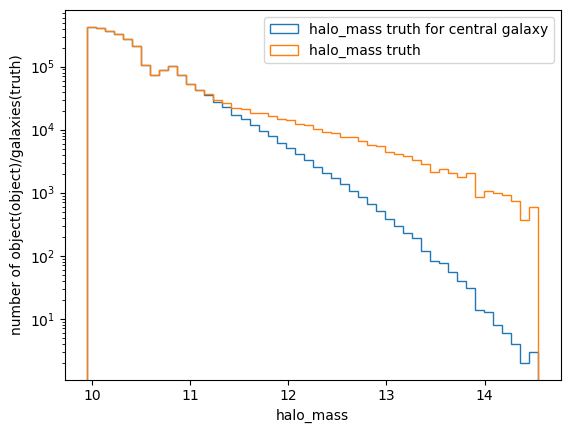

In [42]:
plt.figure()
truth_hist_central=plt.hist(np.log10(truth_data['halo_mass'])[np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='halo_mass truth for central galaxy', log=True)
truth_hist=plt.hist(np.log10(truth_data['halo_mass']), bins=50, histtype='step', label='halo_mass truth', log=True)
plt.legend()
plt.xlabel('halo_mass')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

In [31]:
indice=np.where(truth_data['is_central']==True)[0]
redshift=truth_data['redshift']
halo_mass=truth_data['halo_mass']
mag_i=truth_data['mag_i']
galaxy_id=truth_data['galaxy_id']
is_central=truth_data['is_central']

In [33]:
len(redshift[indice])

2735018

### FoF algo :

In [43]:
list(truth_data)

['redshift', 'halo_mass', 'ra', 'mag_i', 'is_central', 'dec', 'galaxy_id']

In [ ]:
truth_data['is_central']

In [50]:
truth_data['redshift'][truth_data['is_central']]

KeyError: ('redshift', 'is_central')

In [14]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, find by manon ramel

In [54]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                    linking_lengths=my_linking_length)

In [53]:
FoFCatalogMatching?

Type:        module
String form: <module 'FoFCatalogMatching' from '/pbs/throng/lsst/software/desc/common/miniconda/dp-v1.1.0/lib/python3.10/site-packages/FoFCatalogMatching.py'>
File:        /pbs/throng/lsst/software/desc/common/miniconda/dp-v1.1.0/lib/python3.10/site-packages/FoFCatalogMatching.py
Docstring:   FoFCatalogMatching

In [16]:
results

row_index,catalog_key,group_id
int64,str6,int64
0,object,0
2612665,galaxy,0
1,object,1
595257,galaxy,1
2,object,2
591883,galaxy,2
3,object,3
773070,galaxy,3
4,object,4
